The work is heavily inspired by the following works:
    - https://www.pyimagesearch.com/2017/07/24/bank-check-ocr-with-opencv-and-python-part-i
    - https://www.datacamp.com/community/tutorials/tensorflow-tutorial


In [1]:
import os
import cv2
import random
import imutils
import argparse
import numpy as np
from imutils import contours

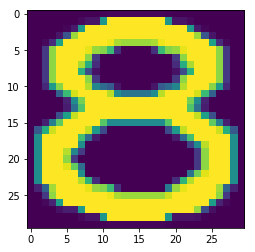

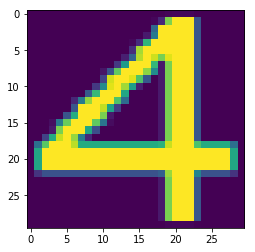

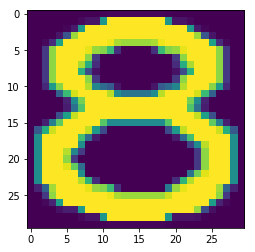

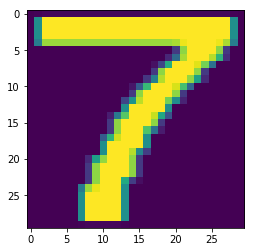

In [87]:
def fetch_symbols_from_captcha(image_path):
    ''' Fetch symbols from a given captcha'''
    
    # load the image
    image = cv2.imread(image_path) 

    # convert it to grayscale, blur it slightly, then find edges
    ref = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    
    ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#     plt.imshow(ref)
#     plt.show()

    # find contours in the images
    refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
    refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

    symbols = []
    padding = 1
    
    # loop over the (sorted) contours
    for index, c in enumerate(refCnts):

        # compute the bounding box of the contour and draw it on our image
        (x, y, w, h) = cv2.boundingRect(c)
        _croped = ref[y-padding:y+h+padding, x-padding:x+w+padding]
        _croped = cv2.resize(_croped, (30, 30))
#         plt.imshow(_croped)
#         plt.show()
        cv2.imwrite('images/{0}-captcha.png'.format(index), _croped)
        symbols.append(_croped)
        
    # show the output of applying the simple contour method
    # cv2.imshow('SimpleImageShower-ref', ref)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return symbols

import matplotlib.pyplot as plt
symbols = fetch_symbols_from_captcha('images\captcha5.png')

for image in symbols:    
    plt.imshow(image)
    plt.show()

In [134]:
def load_data(data_directory):
    ''' Load images from the given repository'''
    
    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels, images = [], []
    for d in directories:

        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f)
                      for f in os.listdir(label_directory)
                      if f.endswith(".png")]
        
        padding = 1
        for f in file_names:            
            _image = cv2.imread(f)
            _image_gray = cv2.cvtColor(_image, cv2.COLOR_BGR2GRAY)
            _image_gray = cv2.threshold(_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            
            # image must be processed in the save way as the one from captcha
            _ref_cnts = cv2.findContours(_image_gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            _ref_cnts = _ref_cnts[0] if imutils.is_cv2() else _ref_cnts[1]
            _ref_cnts = contours.sort_contours(_ref_cnts, method="left-to-right")[0]
            (x, y, w, h) = cv2.boundingRect(_ref_cnts[0])
            _croped = _image_gray[y-padding:y+h+padding, x-padding:x+w+padding]
            _croped = cv2.resize(_croped, (30, 30))           
            
            images.append(_croped)
            labels.append(int(d))

    return images, labels

In [94]:
symbols = fetch_symbols_from_captcha('images\captcha4.png')

0


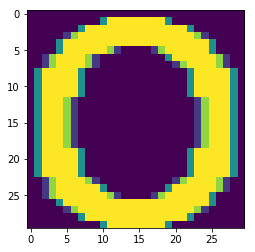

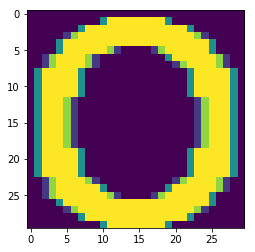

In [129]:
train_dir = 'c:\\repositories\\pycaptcha\\train\\'
images, labels = load_data(train_dir)

# simple check
print(labels[0])
plt.imshow(images[0] / 255.0)
plt.show()
plt.imshow(images[0])
plt.show()

### TensorFlow Variant 1

In [13]:
def train_model_tf(images, labels, symbols_on_captcha):

    import tensorflow as tf

    # Initialize placeholders
    x = tf.placeholder(dtype = tf.float32, shape = [None, 50, 50])
    y = tf.placeholder(dtype = tf.int32, shape = [None])

    # Flatten the input data
    images_flat = tf.contrib.layers.flatten(x)

    # Fully connected layer
    logits = tf.contrib.layers.fully_connected(images_flat, 10, tf.nn.relu)


    # Define loss
    diff = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
    loss = tf.reduce_mean(diff)

    # Define an optimizer
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # Convert logits to label indexes
    correct_pred = tf.argmax(logits, 1)

    # Define an accuracy metric
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    print("images_flat: ", images_flat)
    print("logits: ", logits)
    print("loss: ", loss)
    print("predicted_labels: ", correct_pred)

    tf.set_random_seed(11)

    #images = np.array(images)

    #images = images / 255.0

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # train
    for i in range(300):
        #_, accuracy_value = sess.run([train_op, accuracy], feed_dict={x: images, y: labels})
        _, accuracy_value = sess.run([train_op, accuracy], feed_dict={x: images, y: labels})
        if i % 10 == 0 and i != 0:
            print("iteration: {}, accuracy: {} ".format(i, accuracy_value))

    # Pick some random images
    sample_indexes = random.sample(range(len(images)), 10)
    #sample_indexes = [x for x in range(0, len(images),6)]
    sample_images = [images[i] for i in sample_indexes]
    sample_labels = [labels[i] for i in sample_indexes]
    sample_labels = np.array(sample_labels)

    # for value in sample_images:
    #     cv2.imshow('SimpleImageShower', value)
    #     cv2.waitKey(0)

    # Run the "predicted_labels
    predicted = sess.run([correct_pred], feed_dict={x: sample_images})[0]

    # Print the real and predicted labels
    print(sample_labels)
    print(predicted)

    # calculate accuracy of the test sample
    diff = predicted - sample_labels
    accuracy_cal = (len(diff)-np.count_nonzero(diff)) / len(diff)
    print (accuracy_cal)
    #print(images[0])

    for index, symbol in enumerate(symbols_on_captcha):
        symbol = cv2.normalize(symbol, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #symbol = cv2.cvtColor(symbol, cv2.COLOR_BGR2GRAY)
        # _image = cv2.imread('images/{0}-captcha.png'.format(index))
        # _image_gray = cv2.cvtColor(_image, cv2.COLOR_BGR2GRAY)
        # symbol = _image_gray
        predicted = sess.run([correct_pred], feed_dict={x: [symbol]})[0]
        print(predicted)
        cv2.imshow('SimpleImageShower', symbol)
        cv2.waitKey(0)

    sess.close()

### TensorFlow Variant 2

In [130]:
import tensorflow as tf

def train_model_tf_v2(images, labels, symbols_on_captcha):

    LABEL_SIZE = 10
    IMAGE_SIZE = 30 * 30
    print('label_size: %s, image_size: %s' % (LABEL_SIZE, IMAGE_SIZE))

    # variable in the graph for input data
    x = tf.placeholder(tf.float32, [None, IMAGE_SIZE])
    y_ = tf.placeholder(tf.float32, [None, LABEL_SIZE])

    # define the model
    W = tf.Variable(tf.zeros([IMAGE_SIZE, LABEL_SIZE]))
    b = tf.Variable(tf.zeros([LABEL_SIZE]))
    y = tf.matmul(x, W) + b

    # Define loss and optimizer
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    cross_entropy = tf.reduce_mean(diff)
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    # forward prop
    predict = tf.argmax(y, axis=1)
    expect = tf.argmax(y_, axis=1)

    # evaluate accuracy
    correct_prediction = tf.equal(predict, expect)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    images_resized = []
    for image in images:
        #image = tf.image.per_image_standardization(image)
        image = image / 255.0
        image = image.reshape(30 * 30)
        images_resized.append(image)
    images_resized = np.array(images_resized)
    print(images_resized.shape)

    labels_resized = []
    for index, label in enumerate(labels):
        labels_resized.append([0 for x in range(10)])
        labels_resized[index][label] = 1
        #if label == 5: print(labels_resized[index])
    labels_resized = np.array(labels_resized)
    print(labels_resized.shape)
    print(labels_resized[0])

    tf_sess = tf.Session()
    tf_sess.run(tf.global_variables_initializer())   
    
    MAX_STEPS = 200
    
    # Train
    for i in range(MAX_STEPS):
        tf_sess.run(train_step, feed_dict={x: images_resized, y_: labels_resized})
        if i % 10 == 0:
            r = tf_sess.run(accuracy, feed_dict={x: images_resized, y_: labels_resized})
            print('step = %s, accuracy = %.2f%%' % (i, r * 100))
                
    return tf_sess, x, y

tf_sess, x, y = train_model_tf_v2(images, labels, symbols)

label_size: 10, image_size: 900
(5000, 900)
(5000, 10)
[1 0 0 0 0 0 0 0 0 0]
step = 0, accuracy = 100.00%
step = 10, accuracy = 100.00%
step = 20, accuracy = 100.00%
step = 30, accuracy = 100.00%
step = 40, accuracy = 100.00%
step = 50, accuracy = 100.00%
step = 60, accuracy = 100.00%
step = 70, accuracy = 100.00%
step = 80, accuracy = 100.00%
step = 90, accuracy = 100.00%
step = 100, accuracy = 100.00%
step = 110, accuracy = 100.00%
step = 120, accuracy = 100.00%
step = 130, accuracy = 100.00%
step = 140, accuracy = 100.00%
step = 150, accuracy = 100.00%
step = 160, accuracy = 100.00%
step = 170, accuracy = 100.00%
step = 180, accuracy = 100.00%
step = 190, accuracy = 100.00%


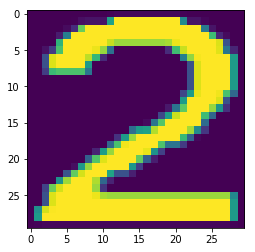

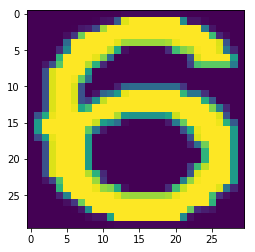

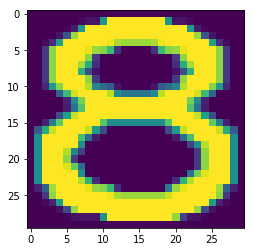

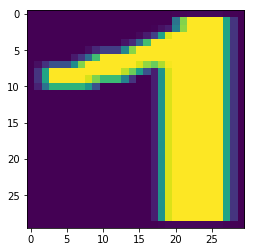

(4, 900)
[2]
[6]
[8]
[1]


In [131]:
#symbols = fetch_symbols_from_captcha('images\captcha4.png')
#symbols = fetch_symbols_from_captcha('images\captcha5.png')
symbols = fetch_symbols_from_captcha('images\captcha6.png')

input_resized = []
for image in symbols:
    image = image / 255.0
    plt.imshow(image)
    plt.show()
    
    image = image.reshape(30 * 30)
    input_resized.append(image)    
input_resized = np.array(input_resized)
print(input_resized.shape)

for image in input_resized:
    predicted = tf_sess.run(tf.argmax(y, axis=1), feed_dict={x: [image]})
    print(predicted)

In [132]:
data_directory = 'c:\\repositories\\pycaptcha\\.captchas\\'
directories = [d for d in os.listdir(data_directory)
               if os.path.isdir(os.path.join(data_directory, d))]
accuracy = 0

for d in directories:
    sub_directory = os.path.join(data_directory, d)
    
    label_path = os.path.join(sub_directory, d) + '.ans'
    label = 0    
    with open(label_path, 'r') as _file:
        label = _file.read().strip()
        
    image_path = os.path.join(sub_directory, d) + '.png'
    symbols = fetch_symbols_from_captcha(image_path)
    
    input_resized = []
    for image in symbols:
        image = image / 255.0
        image = image.reshape(30 * 30)
        input_resized.append(image)
    input_resized = np.array(input_resized)
    #print(input_resized.shape)
    correct, wrong = 0, 0
    for index, image in enumerate(input_resized):
        predicted = tf_sess.run(tf.argmax(y, axis=1), feed_dict={x: [image]})
        diff = int(predicted[0]) - int(label[index])
        if diff == 0:
            correct+=1
        else:
            wrong+=1
            print (predicted[0], label[index], d)
            
    accuracy += correct / len(symbols)
    
print('accuracy: {}'.format(accuracy/len(directories)))

accuracy: 1.0


In [33]:
def train_model_keras_mnist(images, labels, symbols_on_captcha, retrain = True):

    import tensorflow as tf
    #from keras.layers import Input, Flatten

    mnist = tf.keras.datasets.mnist
    MODEL_NAME = 'keras-mnist-model.h5'

    if not os.path.exists(MODEL_NAME) or retrain:
        (x_train, y_train),(x_test, y_test) = mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0

        model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation=tf.nn.relu),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        #model.fit(images, labels, epochs=1)
        model.fit(x_train, y_train, epochs=1)
        tf.keras.models.save_model(model, MODEL_NAME)
    else:
        model = tf.keras.models.load_model(MODEL_NAME)

    # images_resized = []
    # for image in images:
    #     _image = cv2.resize(image, (28, 28))
    #     images_resized.append(_image)

    # # v1 - doesn't work properly
    # for index, image in enumerate(images_resized):
    #     _x = np.expand_dims(image, axis=0)
    #     _x = np.vstack([_x])
    #     predicted = model.predict(_x)
    #     print(predicted)
    #     print(labels[index])

    # # v2 - doesn't work properly
    # images_resized  = np.array(images_resized)
    # for index, image in enumerate(images_resized):
    #     predicted = model.predict(image)
    #     print(predicted)
    #     print(labels[index])
    # #     print(type(image))

    #     cv2.imshow('SimpleImageShower', image)
    #     cv2.waitKey(0)
    #     print ('predicted: {}, real: {}'.format(predicted, labels[index]))

    for index, symbol in enumerate(symbols_on_captcha):
        #symbol = cv2.cvtColor(symbol, cv2.COLOR_BGR2GRAY)
        _image = cv2.imread('images/{0}-captcha.png'.format(index))
        _image = cv2.normalize(_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #_image_gray = cv2.cvtColor(_image, cv2.COLOR_BGR2GRAY)
        _image_gray = cv2.resize(_image_gray, (28, 28))
        symbol = _image_gray
        #symbol = np.array(symbol)
        #symbol = symbol.flatten()
        # symbol = tf.keras.layers.Input(symbol)
        # symbol = tf.keras.layers.Flatten()(symbol)
        #print(symbol.shape)
        symbol = np.expand_dims(symbol, axis=0)
        symbol = np.vstack([symbol])
        #symbol = symbol / 255.0
        predicted = model.predict_classes(symbol, batch_size=1, verbose=1)
        print(predicted)
        # cv2.imshow('SimpleImageShower', _image)
        # cv2.waitKey(0)